In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.functional as F
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [26]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, inputs):
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self.embedding_dim)
        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight ** 2, dim=1) - 2 * torch.matmul(flat_input, self.embedding.weight.t()))
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        quantized = inputs + (quantized - inputs).detach()
        return loss, quantized, encoding_indices

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, x):
        _, hidden = self.rnn(x)
        return self.linear(hidden.squeeze(0))

class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, length):
        super().__init__()
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.length = length

    def forward(self, x):
        x = x.repeat(self.length, 1, 1).transpose(0, 1)
        output, _ = self.rnn(x)
        return self.linear(output)

def generate_helix_trajectories(n_samples=1000, length=100, radius=1, pitch=0.1, turns=3, noise_level=0.2):
    t = np.linspace(0, 2 * np.pi * turns, length)
    data = []
    for _ in range(n_samples):
        noisy_radius = radius + np.random.normal(0, noise_level, size=(length,))
        x = noisy_radius * np.cos(t)
        y = noisy_radius * np.sin(t)
        z = pitch * t
        helix = np.stack((x, y, z), axis=1)
        data.append(helix)
    return torch.tensor(data, dtype=torch.float32)

In [27]:

dataset = generate_helix_trajectories(n_samples=100, length=100, turns=1)
loader = DataLoader(TensorDataset(dataset), batch_size=32, shuffle=True)

In [28]:

encoder = Encoder(3, 64, 64).to(device)
decoder = Decoder(64, 64, 3, 100).to(device)
vector_quantizer = VectorQuantizer(10, 64, 0.25).to(device)
params = list(encoder.parameters()) + list(decoder.parameters()) + list(vector_quantizer.parameters())
optimizer = optim.Adam(params, lr=0.0001)
epochs = 500


In [ ]:

for epoch in range(epochs):
    total_loss = 0
    for batch, in loader:
        batch = batch[0].to(device)
        optimizer.zero_grad()
        z = encoder(batch)
        loss, quantized, _ = vector_quantizer(z)
        reconstructions = decoder(quantized)
        recon_loss = F.mse_loss(reconstructions, batch)
        total_loss = recon_loss + loss
        total_loss.backward()
        optimizer.step()
    if(epoch +1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {total_loss.item()}')
        
torch.save(encoder.state_dict(), '/Users/navaneet/dld-test/vqvae/models/Encoder.pth')
torch.save(decoder.state_dict(), '/Users/navaneet/dld-test/vqvae/models/Decoder.pth')
torch.save(vector_quantizer.state_dict(), '/Users/navaneet/dld-test/vqvae/models/VectorQuantizer.pth')

Epoch 1/500:   0%|          | 0/4 [00:00<?, ?batch/s]/var/folders/pf/f4rqz02s41zb52mj8sy1l8qc0000gn/T/ipykernel_8400/3043184518.py:11: UserWarning: Using a target size (torch.Size([100, 3])) that is different to the input size (torch.Size([1, 100, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = F.mse_loss(reconstructions, batch)
Epoch 22/500:   0%|          | 0/4 [00:00<?, ?batch/s]


KeyboardInterrupt: 

In [21]:
# Load the trained model weights
encoder.load_state_dict(torch.load('models/Encoder.pth'))
decoder.load_state_dict(torch.load('models/Decoder.pth'))
vector_quantizer.load_state_dict(torch.load('models/VectorQuantizer.pth'))

<All keys matched successfully>

In [22]:
encoder.eval()
decoder.eval()
vector_quantizer.eval()

VectorQuantizer(
  (embedding): Embedding(10, 64)
)

In [23]:
with torch.no_grad():
    sample = next(iter(loader))[0].to(device)
    encoded = encoder(sample)
    _, quantized, encoding_indices = vector_quantizer(encoded)
    reconstructed = decoder(quantized)
    original_data = sample[0].cpu().numpy()
    reconstructed_data = reconstructed[0].cpu().numpy()

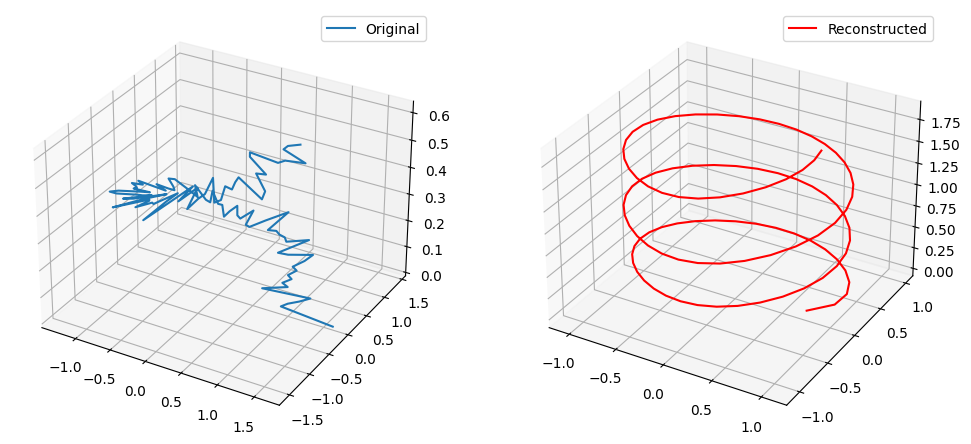

In [24]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(original_data[:, 0], original_data[:, 1], original_data[:, 2], label='Original')
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(reconstructed_data[:, 0], reconstructed_data[:, 1], reconstructed_data[:, 2], label='Reconstructed', color='r')
ax2.legend()
plt.show()
